##  Custom regression models

Like for univariate models, it is possible to create your own custom parametric survival models. Why might you want to do this? 

 - Create new / extend AFT models using known probability distributions
 - Create a piecewise model using domain knowledge about subjects
 - Iterate and fit a more accurate parametric model

*lifelines* has a very simple API to create custom parametric regression models. The author only needs to define the cumulative hazard function. For example, the cumulative hazard for the Exponential regression model looks like:

$$ 
H(t, x) = \frac{t}{\lambda(x)}\\ \lambda(x) = \exp{(\vec{\beta} \cdot \vec{x}^{\,T})}
$$ 



Below are some example custom models.

In [1]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi


class ExponentialAFTFitter(ParametricRegressionFitter):
    
    # this is necessary, and should always be a non-empty list of strings. 
    _fitted_parameter_names = ['lambda_']
    
    def _cumulative_hazard(self, params, T, Xs):
        # params is a dictionary that maps unknown parameters to a numpy vector. 
        # Xs is a dictionary that maps unknown parameters to a numpy 2d array 
        lambda_ = np.exp(np.dot(Xs['lambda_'], params['lambda_']))
        return T / lambda_
    

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda_': rossi.columns
}

eaf = ExponentialAFTFitter().fit(rossi, 'week', 'arrest', regressors=regressors)
eaf.print_summary()

<lifelines.ExponentialAFTFitter: fitted with 432 observations, 318 censored>
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -686.37
  time fit was run = 2019-07-03 01:56:13 UTC

---
                   coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_ fin        0.37      1.44      0.19  1.92   0.06      4.18       -0.01        0.74
        age        0.06      1.06      0.02  2.55   0.01      6.52        0.01        0.10
        race      -0.30      0.74      0.31 -0.99   0.32      1.63       -0.91        0.30
        wexp       0.15      1.16      0.21  0.69   0.49      1.03       -0.27        0.56
        mar        0.43      1.53      0.38  1.12   0.26      1.93       -0.32        1.17
        paro       0.08      1.09      0.20  0.42   0.67      0.57       -0.30        0.47
        prio      -0.09      0.92      0.03 -3.03 <0.005      8.65       -0.14       -0.03
        intercept  4.05     57.44   

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1510: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(self.variance_matrix_.diagonal())


<lifelines.PolynomialCumulativeHazard: fitted with 432 observations, 318 censored>
         event col = 'arrest'
         penalizer = 0.5
number of subjects = 432
  number of events = 114
    log-likelihood = -680.15
  time fit was run = 2019-07-03 01:56:13 UTC

---
                    coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda1_ fin        0.25      1.28      0.18  1.40   0.16      2.64       -0.10        0.60
         age        0.04      1.05      0.02  2.29   0.02      5.49        0.01        0.08
         race      -0.30      0.74      0.28 -1.04   0.30      1.75       -0.85        0.26
         wexp       0.15      1.16      0.19  0.77   0.44      1.18       -0.23        0.52
         mar        0.30      1.35      0.31  0.98   0.33      1.61       -0.30        0.91
         paro       0.06      1.06      0.18  0.31   0.76      0.40       -0.30        0.42
         prio      -0.06      0.94      0.03 -2.15   0.03      4.99       -0.12       -0.

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1510: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(self.variance_matrix_.diagonal())


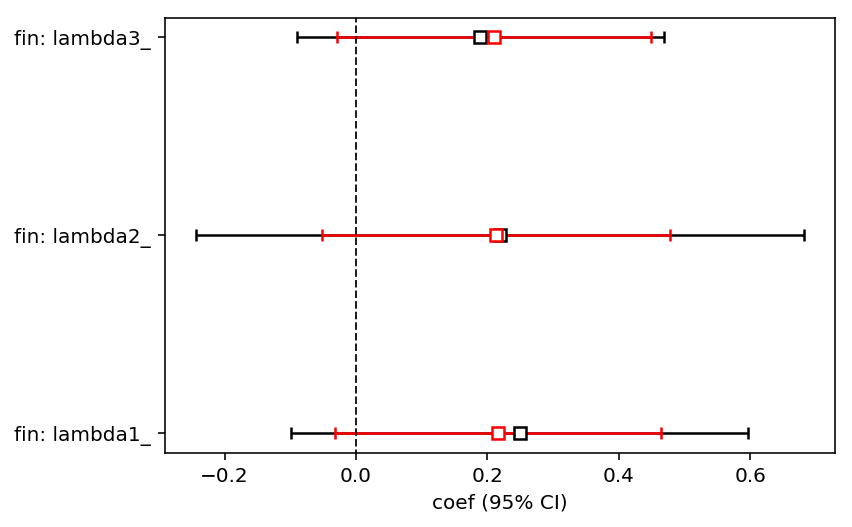

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np

class PolynomialCumulativeHazard(ParametricRegressionFitter):
    
    _fitted_parameter_names = ['lambda1_', 'lambda2_', 'lambda3_']
    
    def _cumulative_hazard(self, params, T, Xs):
        lambda1_ = np.exp(np.dot(Xs['lambda1_'], params['lambda1_']))
        lambda2_ = np.exp(np.dot(Xs['lambda2_'], params['lambda2_']))
        lambda3_ = np.exp(np.dot(Xs['lambda3_'], params['lambda3_']))

        return (T/lambda1_) + (T/lambda2_)**2 + (T/lambda3_)**3
    
    def _add_penalty(self, params, neg_ll):
        # authors can create their own non-traditional penalty functions too. 
        # This penalty is an "information-pooling" penalty, see more about it here:
        # https://dataorigami.net/blogs/napkin-folding/churn
        params_stacked = np.stack(params.values())
        coef_penalty = 0

        if self.penalizer > 0:
            for i in range(params_stacked.shape[1] - 1):  # assuming the intercept col is the last column...
                coef_penalty = coef_penalty + (params_stacked[:, i]).var()

        return neg_ll + self.penalizer * coef_penalty

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda1_': rossi.columns,
    'lambda2_': rossi.columns,
    'lambda3_': rossi.columns
}

pf = PolynomialCumulativeHazard(penalizer=.5).fit(rossi, 'week', 'arrest', regressors=regressors)
pf.print_summary()

ax = plt.subplot()
pf.plot(columns=['fin'], ax=ax)

pf = PolynomialCumulativeHazard(penalizer=5.).fit(rossi, 'week', 'arrest', regressors=regressors)
pf.plot(columns=['fin'], ax=ax, c="r")


### Cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. In this case, the survival function for an individual should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [26]:
from autograd.scipy.special import expit

class CureModel(ParametricRegressionFitter):

    _fitted_parameter_names = ["lambda_", "beta_", "rho_"]

    def _cumulative_hazard(self, params, T, Xs):
        c = expit(np.dot(Xs["beta_"], params["beta_"]))

        lambda_ = np.exp(np.dot(Xs["lambda_"], params["lambda_"]))
        rho_ = np.exp(np.dot(Xs["rho_"], params["rho_"]))
        sf = np.exp(-(T / lambda_) ** rho_)

        return -np.log((1 - c) + c * sf)


swf = CureModel(penalizer=.1)

rossi = load_rossi()
rossi["intercept"] = 1.0

covariates = {"lambda_": rossi.columns, "rho_": ["intercept", "prio"], "beta_": rossi.columns}

swf.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.arange(250)) 
swf.print_summary(2)

<lifelines.CureModel: fitted with 432 observations, 318 censored>
         event col = 'arrest'
         penalizer = 0.1
number of subjects = 432
  number of events = 114
    log-likelihood = -733.43
  time fit was run = 2019-07-03 02:01:56 UTC

---
                   coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_ fin        0.35      1.42      0.15  2.40   0.02      5.92        0.06        0.64
        age        0.11      1.12      0.01 11.67 <0.005    102.18        0.09        0.13
        race       0.69      1.99      0.19  3.63 <0.005     11.79        0.32        1.06
        wexp       0.45      1.57      0.15  3.06 <0.005      8.84        0.16        0.74
        mar        0.39      1.48      0.23  1.69   0.09      3.45       -0.06        0.85
        paro       0.21      1.23      0.15  1.35   0.18      2.49       -0.09        0.51
        prio       0.02      1.02      0.02  0.72   0.47      1.08       -0.03        0.06
        intercept  0.2

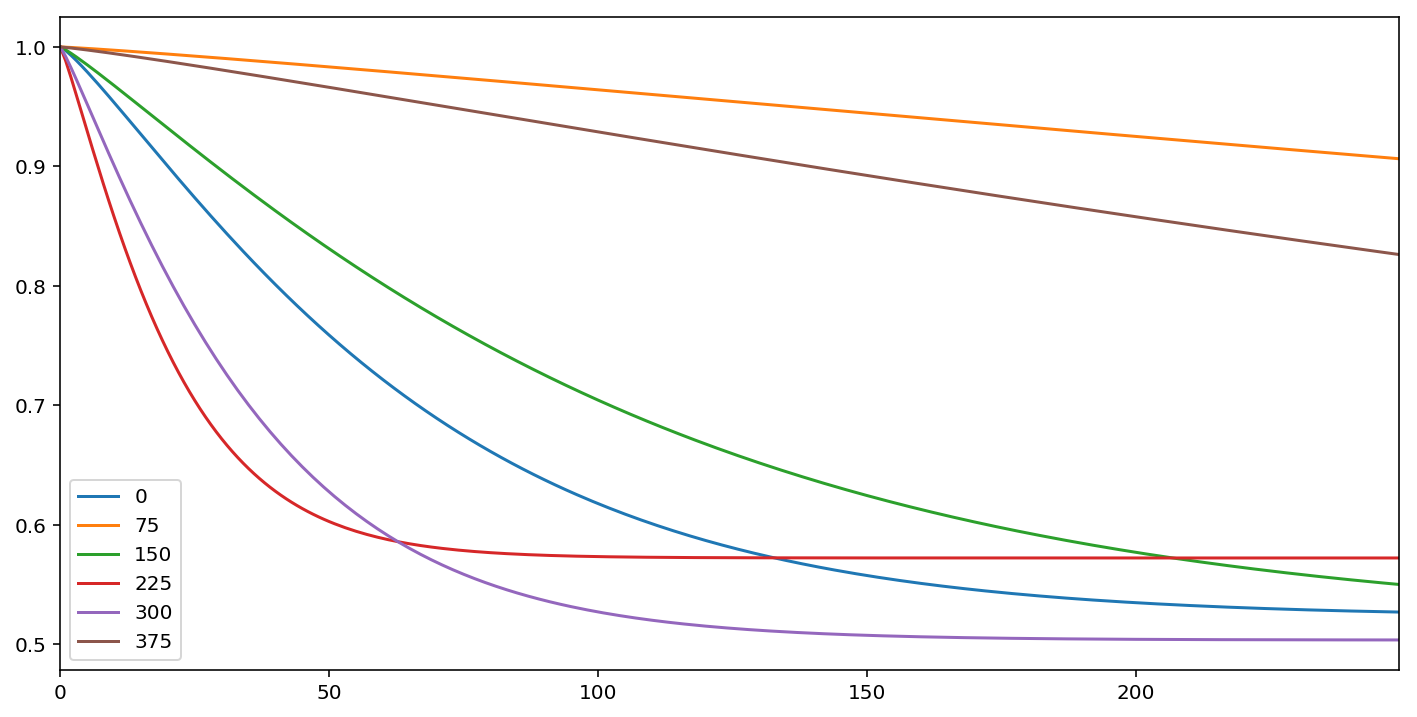

In [27]:
swf.predict_survival_function(rossi.loc[::75]).plot(figsize=(12,6))

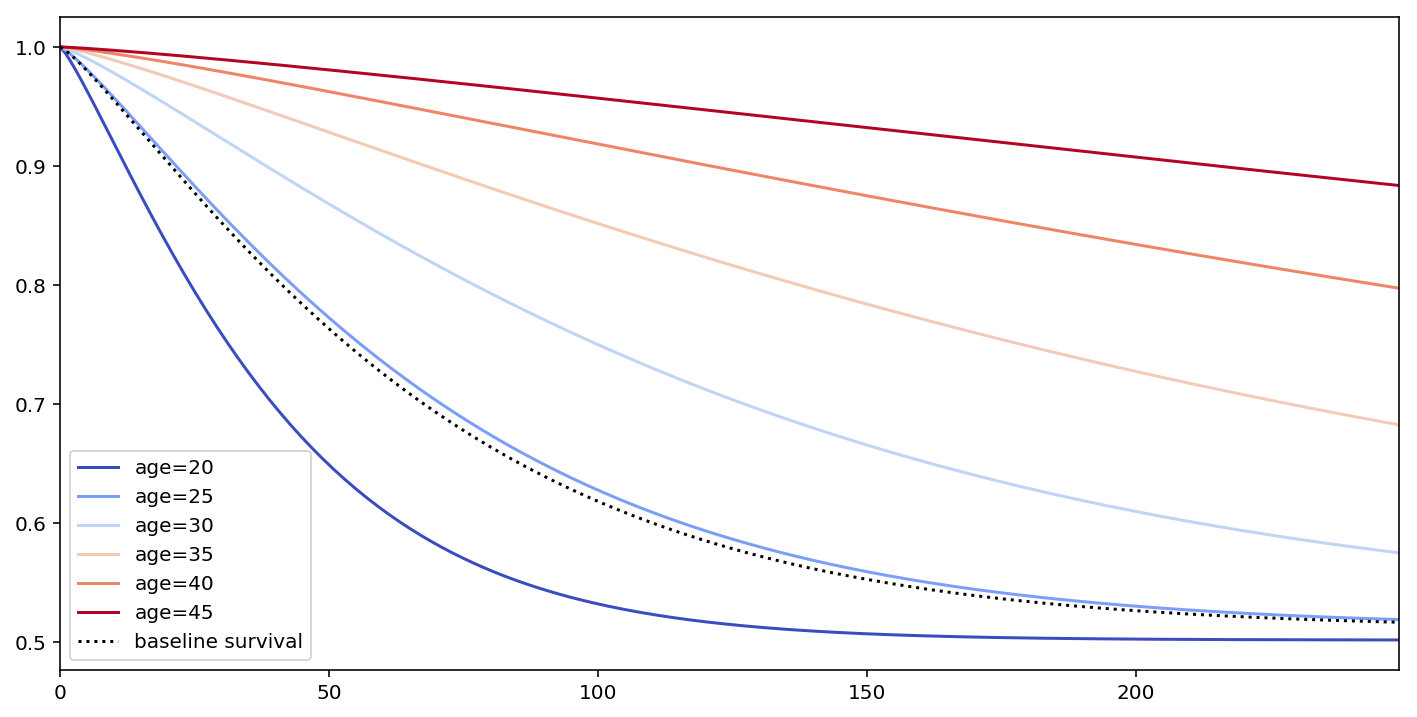

In [30]:
# what's the effect on the survival curve if I vary "age"
fig, ax = plt.subplots(figsize=(12, 6))

swf.plot_covariate_groups(['age'], values=np.arange(20, 50, 5), cmap='coolwarm', ax=ax)